In [1]:
using BioAlignments
using FASTX
using ProgressMeter
using Printf
using CSV
using Plots
using StatsPlots
using StatsBase
using Distributions
using HypothesisTests
include("source/utils.jl")
include("source/io.jl")
include("source/alignment.jl")
include("source/pctid.jl")
include("source/gumbel.jl");

## Data prep

In [2]:
sprot = readsequences("data/sprot.fa")
filter!(x -> 280 <= length(x) < 320, sprot)
writesequences("data/sprot300.fa", sprot)
rev_sprot = reverse.(sprot)
writesequences("data/rev_sprot300.fa", rev_sprot)
shuf_sprot = shufflefast.(repeat(sprot, 10))
writesequences("data/shuf_sprot300.fa", shuf_sprot)
rev_shuf_sprot = reverse.(shuf_sprot)
writesequences("data/rev_shuf_sprot300.fa", rev_shuf_sprot)

In [3]:
masked_sprot = readsequences("data/masked_sprot.fa")
filter!(x -> 280 <= length(x) < 320, masked_sprot)
masked_sprot = replace.(masked_sprot, 'X'=>"")
writesequences("data/masked_sprot300.fa", masked_sprot)
rev_masked_sprot = reverse.(masked_sprot)
writesequences("data/rev_masked_sprot300.fa", rev_masked_sprot)
shuf_masked_sprot = shufflefast.(repeat(masked_sprot, 10))
writesequences("data/shuf_masked_sprot300.fa", shuf_masked_sprot)
rev_shuf_masked_sprot = reverse.(shuf_masked_sprot)
writesequences("data/rev_shuf_masked_sprot300.fa", rev_shuf_masked_sprot);

## Align for score

In [4]:
alignmentscore(x1, x2) = align(Pairwise(), x1, x2;
    formatter=x::PairwiseAlignmentResult -> score(x)::Int,
    verbose=true)

alignmentscore (generic function with 1 method)

In [5]:
sprot = readsequences("data/sprot300.fa")
rev_sprot = readsequences("data/rev_sprot300.fa")
shuf_sprot = readsequences("data/shuf_sprot300.fa")
rev_shuf_sprot = readsequences("data/rev_shuf_sprot300.fa")
masked_sprot = readsequences("data/masked_sprot300.fa")
rev_masked_sprot = readsequences("data/rev_masked_sprot300.fa")
shuf_masked_sprot = readsequences("data/shuf_masked_sprot300.fa")
rev_shuf_masked_sprot = readsequences("data/rev_shuf_masked_sprot300.fa");

In [6]:
scores_shuf = alignmentscore(shuf_sprot, shufflefast.(shuf_sprot));

Aligning... 100%|████████████████████████████████████████| Time: 0:01:022:19


In [7]:
scores_rev = alignmentscore(sprot, rev_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [8]:
scores_shufrev = alignmentscore(shuf_sprot, rev_shuf_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:01:02


In [9]:
scores_maskedshuf = alignmentscore(shuf_masked_sprot, shufflefast.(shuf_masked_sprot));

Aligning... 100%|████████████████████████████████████████| Time: 0:00:58


In [10]:
scores_maskedrev = alignmentscore(masked_sprot, rev_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:05


In [11]:
scores_maskedshufrev = alignmentscore(shuf_masked_sprot, rev_shuf_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:01:11


## Fit Gumbel Distributions to Score Data

For general information on Gumbel distributions:

https://en.wikipedia.org/wiki/Gumbel_distribution

For details on the particular type we are constructing:

https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Gumbel

Because `Distributions.jl` doesn't seem to offer a simple way to fit Gumbel distributions, I made a quick implementation of `fit(Gumbel, data)` by wrapping the codes published in this blog:

https://djalil.chafai.net/blog/2018/02/18/gumbel-fit-with-julia/

In [12]:
S = (
    scores_shuf, scores_rev, scores_shufrev, 
    scores_maskedshuf, scores_maskedrev, scores_maskedshufrev
)
D = (
    gumbel_shuf, gumbel_rev, gumbel_shufrev,
    gumbel_maskedshuf, gumbel_maskedrev, gumbel_maskedshufrev,
) = fit.(Gumbel, S)
D = permutedims(reshape(collect(D), (3,2)))
L = [
    "Gumbel(SP-SH)" "Gumbel(SP-RV)" "Gumbel(SH-SHRV)"; 
    "Gumbel(SP-SH_masked)" "Gumbel(SP-RV_masked)" "Gumbel(SH-SHRV_masked)"
]
display(hcat(L[1,:],D[1,:]))
display(hcat(L[2,:],D[2,:]))

3×2 Matrix{Any}:
 "Gumbel(SP-SH)"    Gumbel{Float64}(μ=34.1247, θ=5.55677)
 "Gumbel(SP-RV)"    Gumbel{Float64}(μ=46.9739, θ=10.6597)
 "Gumbel(SH-SHRV)"  Gumbel{Float64}(μ=45.093, θ=8.93375)

3×2 Matrix{Any}:
 "Gumbel(SP-SH_masked)"    Gumbel{Float64}(μ=33.3686, θ=4.96307)
 "Gumbel(SP-RV_masked)"    Gumbel{Float64}(μ=45.1801, θ=8.70434)
 "Gumbel(SH-SHRV_masked)"  Gumbel{Float64}(μ=44.0853, θ=8.28043)

## Run Anderson-Darling tests

On measuring the goodness of fit of Gumbel distributions:

https://www.semanticscholar.org/paper/The-Goodness-of-fit-Test-for-Gumbel-Distribution:-A-Abidin-Adam/c57f0845b518ab95717634017edeb40aa25b08f2

On the AD test implemented in `HypothesisTests.jl`:

https://juliastats.org/HypothesisTests.jl/v0.6/nonparametric.html#Anderson-Darling-test-1

In [ ]:
#todo

## Kullback-Leibler Divergence of Gumbel Distributions
#### (Computing the...)
Implements the KL divergence derived by Manuel Gil in his thesis:

http://www.mast.queensu.ca/~communications/Papers/gil-msc11.pdf 

which I found via a StackExchange post:

https://stats.stackexchange.com/questions/462346/kl-divergence-for-generalized-extreme-value-distribution

In [ ]:
#todo

## Plot Score Frequencies with Gumbel PDFs

In [14]:
function display_gumbel_pdf(D::Array{Gumbel{T}}, x::S) where {T,S <: Real}
    println("PDF at score=$x")
    display(pdf.(D, x))
end
display(L)
display_gumbel_pdf(D, 75)
display_gumbel_pdf(D, 100)
display_gumbel_pdf(D, 125)
display_gumbel_pdf(D, 150)

2×3 Matrix{String}:
 "Gumbel(SP-SH)"         "Gumbel(SP-RV)"         "Gumbel(SH-SHRV)"
 "Gumbel(SP-SH_masked)"  "Gumbel(SP-RV_masked)"  "Gumbel(SH-SHRV_masked)"

PDF at score=75


2×3 Matrix{Float64}:
 0.000114882  0.00629636  0.00380041
 4.58335e-5   0.00361667  0.0028193

PDF at score=100


2×3 Matrix{Float64}:
 1.27828e-6  0.000643976  0.000239251
 2.97613e-7  0.000211     0.000140867

PDF at score=125


2×3 Matrix{Float64}:
 1.42144e-8  6.20921e-5  1.46018e-5
 1.93207e-9  1.19588e-5  6.88786e-6

PDF at score=150


2×3 Matrix{Float64}:
 1.58063e-10  5.95319e-6  8.89489e-7
 1.25427e-11  6.76674e-7  3.36434e-7

In [15]:
function plot_gumbel_pdf!(d::Gumbel, X::Vector, name, color, style)
    Y = pdf.(d, X)
    plot!(X, Y, label=name, color=color, dpi=300, style=style)
end
colors=theme_palette(:auto);

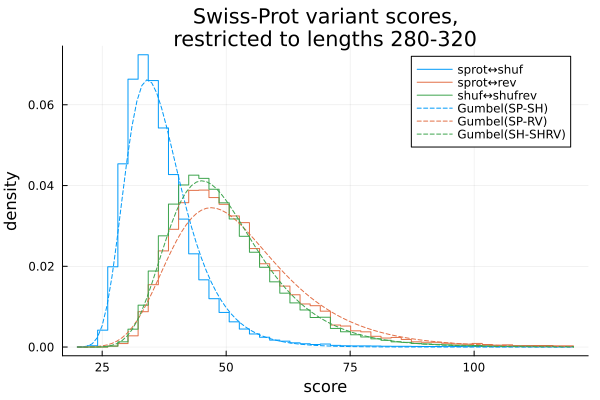

In [16]:
plot(title="Swiss-Prot variant scores,\nrestricted to lengths 280-320",xlabel="score",ylabel="density")
stephist!(scores_shuf, norm=true, bins=range(20,120,50), label="sprot↔shuf", dpi=300)
stephist!(scores_rev, norm=true, bins=range(20,120,50), label="sprot↔rev", dpi=300)
stephist!(scores_shufrev, norm=true, bins=range(20,120,50), label="shuf↔shufrev", dpi=300)
#plot(xlabel="score",ylabel="-pdf")
plot_gumbel_pdf!.(D[1,:], [collect(20:120)], L[1,:], colors[1:3], [:dash])
plot!(dpi=300)
savefig("figures/ScoreRidgelines_sprot")
plot!()

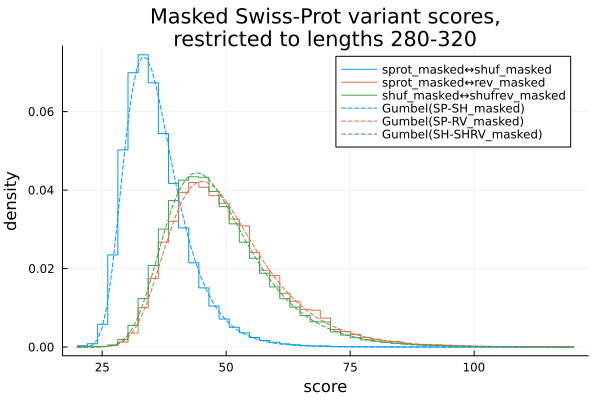

In [17]:
plot(title="Masked Swiss-Prot variant scores,\nrestricted to lengths 280-320",xlabel="score",ylabel="density")
stephist!(scores_maskedshuf, norm=true, bins=range(20,120,50), label="sprot_masked↔shuf_masked", dpi=300)
stephist!(scores_maskedrev, norm=true, bins=range(20,120,50), label="sprot_masked↔rev_masked", dpi=300)
stephist!(scores_maskedshufrev, norm=true, bins=range(20,120,50), label="shuf_masked↔shufrev_masked", dpi=300)
#plot(xlabel="score",ylabel="-pdf")
plot_gumbel_pdf!.(D[2,:], [collect(20:120)], L[2,:], colors[1:3], [:dash])
plot!(dpi=300)
savefig("figures/ScoreRidgelines_masked")
plot!()

## Log PDF Plots 

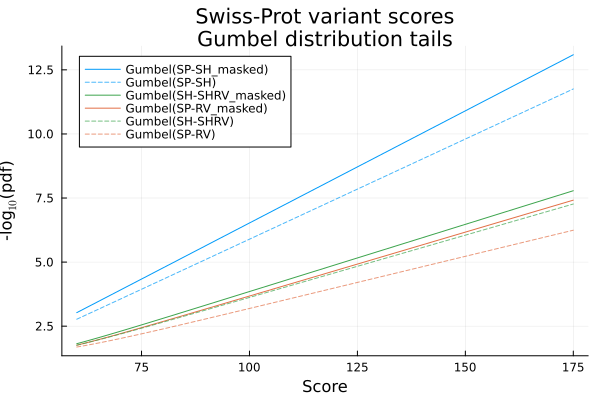

In [18]:
function plot_gumbel_logpdf!(d::Gumbel, X::Vector, name, color; style=:auto, alpha=1)
    Y = -log.(10, pdf.(d, X))
    plot!(X, Y, label=name, linestyle=style, color=color, alpha=alpha, dpi=300)
end
plot(title="Swiss-Prot variant scores\nGumbel distribution tails", xlabel="Score",ylabel="-log\$_{10}\$(pdf)")
X = collect(60:175)
plot_gumbel_logpdf!(D[2,1], X, L[2,1], colors[1]; style=:solid)
plot_gumbel_logpdf!(D[1,1], X, L[1,1], colors[1]; style=:dash, alpha=0.7)
plot_gumbel_logpdf!(D[2,3], X, L[2,3], colors[3]; style=:solid)
plot_gumbel_logpdf!(D[2,2], X, L[2,2], colors[2]; style=:solid)
plot_gumbel_logpdf!(D[1,3], X, L[1,3], colors[3]; style=:dash, alpha=0.7)
plot_gumbel_logpdf!(D[1,2], X, L[1,2], colors[2]; style=:dash, alpha=0.7)
plot!(dpi=300)
savefig("figures/ScoreRidgelines_gumbeltails")
plot!()